In [1]:
from IPython.display import Image

# GNNs

## Motivação

In [24]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

In [5]:
data_path = pathlib.Path("../../data/cora/")

In [6]:
citations = pd.read_csv(
    data_path / "cora.cites",
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [7]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [8]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    data_path / "cora.content", sep="\t", header=None, names=column_names,
)

In [9]:
papers.head()
# papers.head().T

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [10]:
papers["subject"].value_counts()

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64

In [11]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [12]:
class_values
# class_idx
# paper_idx

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [13]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [14]:
papers.head().T

,0,1,2,3,4
paper_id,462,1911,2002,248,519
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


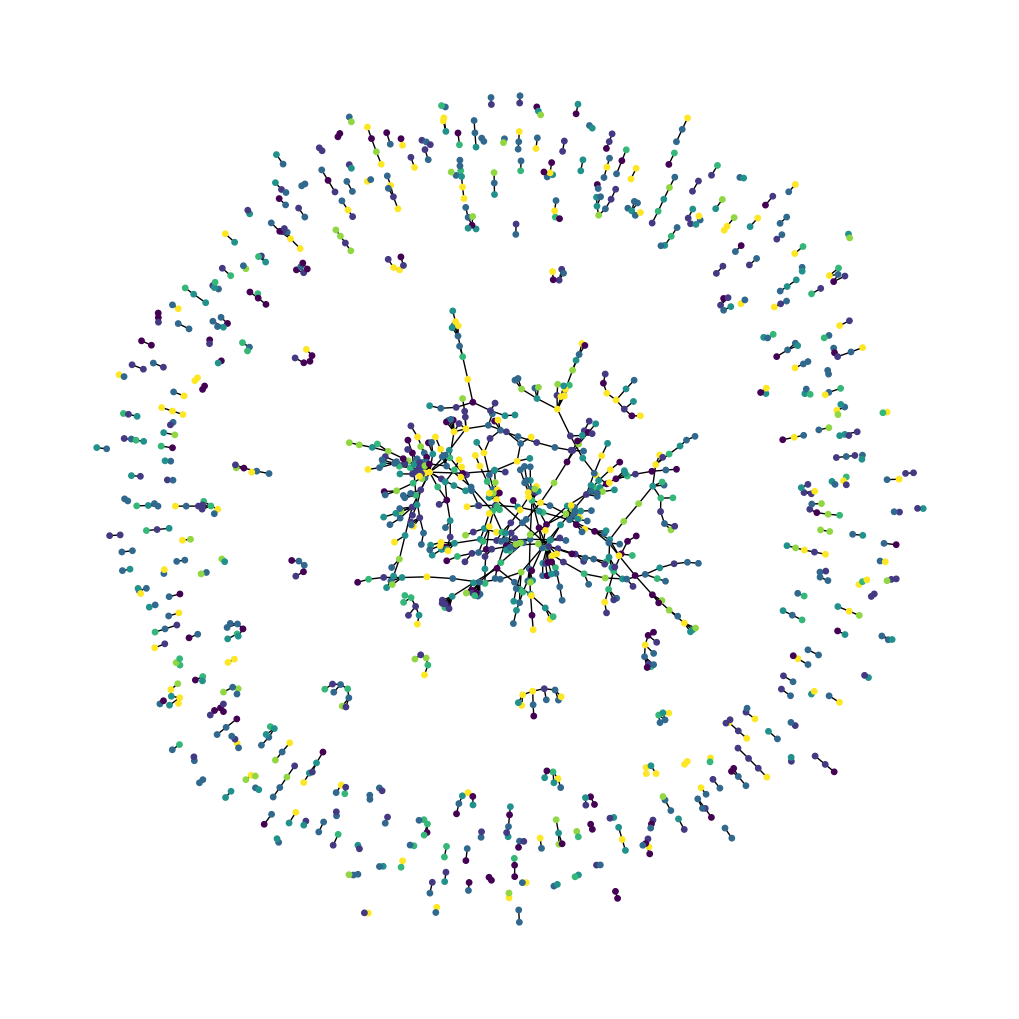

In [15]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1000))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


**Problema: Baseado nos termos de um artigo e nos artigos relacionados, conseguimos prever o seu tópico usando uma rede neural?**

## Convoluções em grafos

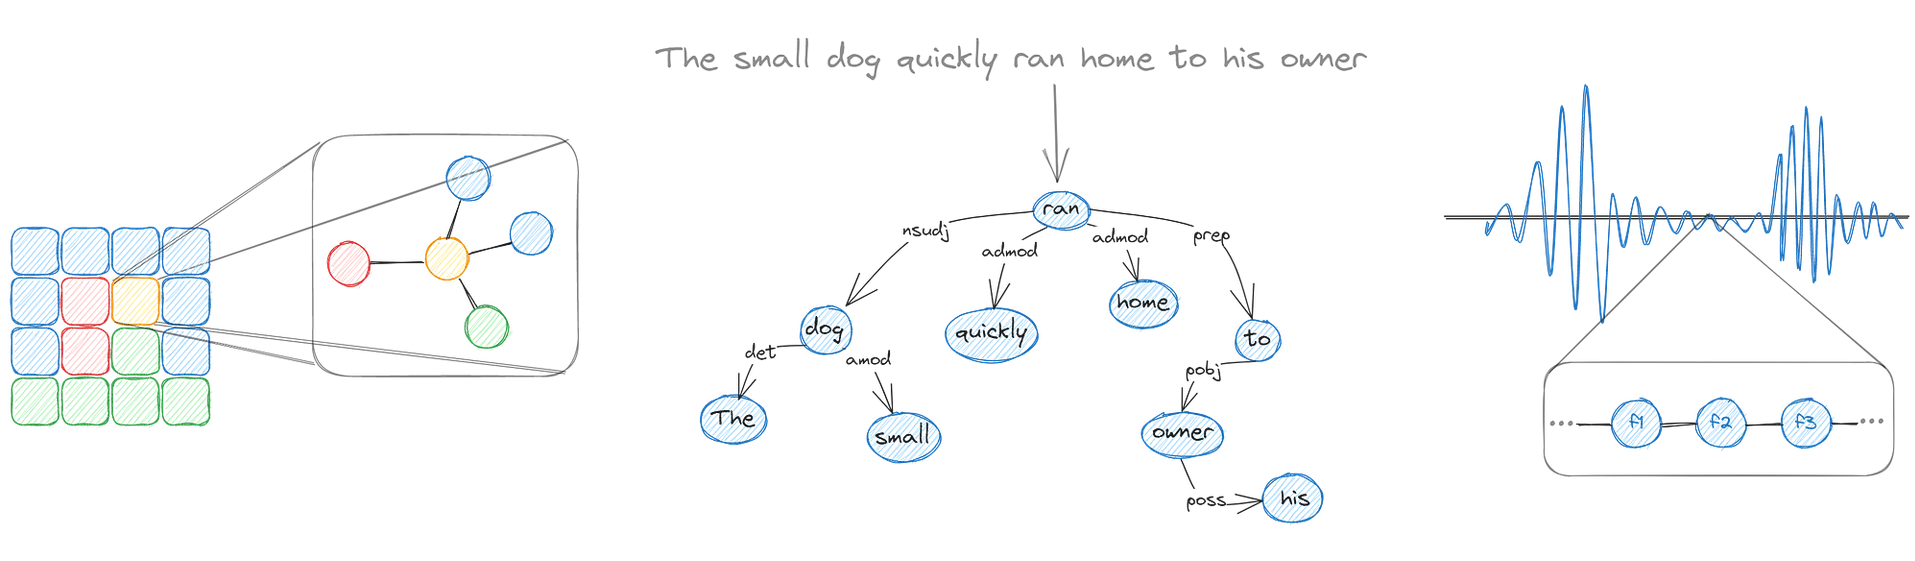

In [16]:
Image(filename='graph_representation.png') 

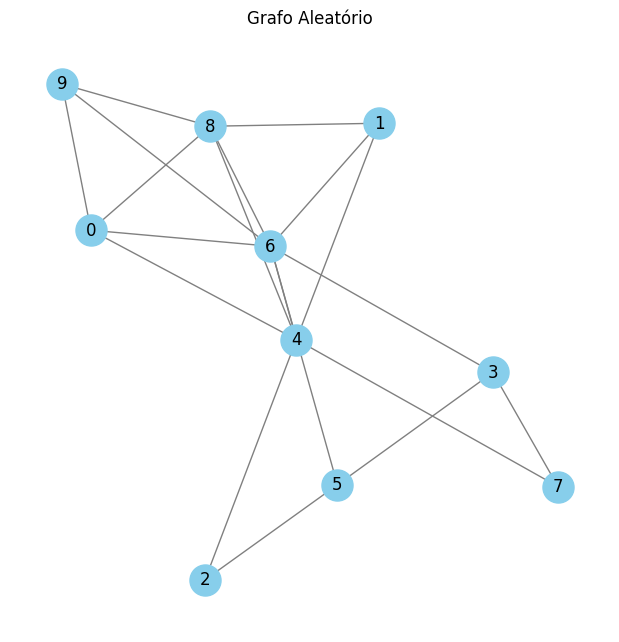

In [19]:
G = nx.erdos_renyi_graph(n=10, p=0.4)

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Grafo Aleatório")
plt.show()

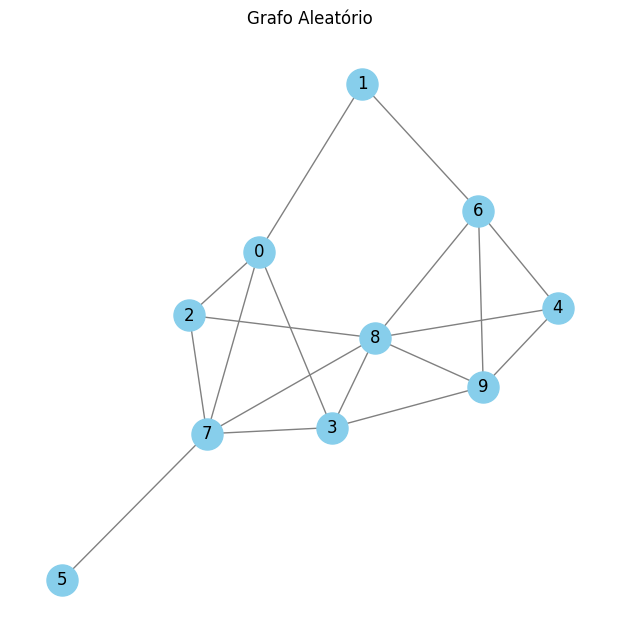

In [29]:
# Gerar um grafo aleatório
G = nx.erdos_renyi_graph(n=10, p=0.4)  # Grafo com 10 nós e probabilidade 0.4 de uma aresta existir

# Plotar o grafo
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title("Grafo Aleatório")
plt.show()

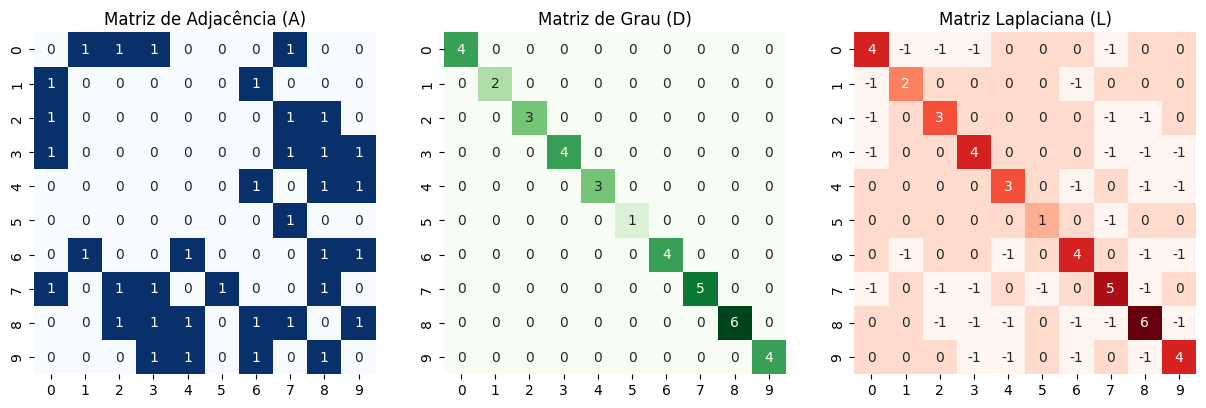

In [32]:
# Matriz de adjacência
A = nx.adjacency_matrix(G).todense()

# Matriz de grau
D = np.diag([d for n, d in G.degree()])

# Laplaciano
L = D - A

# Plotar as matrizes como heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Matriz de Adjacência
sns.heatmap(A, ax=axes[0], cmap='Blues', annot=True, cbar=False, square=True)
axes[0].set_title("Matriz de Adjacência (A)")

# Matriz de Grau
sns.heatmap(D, ax=axes[1], cmap='Greens', annot=True, cbar=False, square=True)
axes[1].set_title("Matriz de Grau (D)")

# Matriz Laplaciana
sns.heatmap(L, ax=axes[2], cmap='Reds', annot=True, cbar=False, square=True)
axes[2].set_title("Matriz Laplaciana (L)")

plt.show()

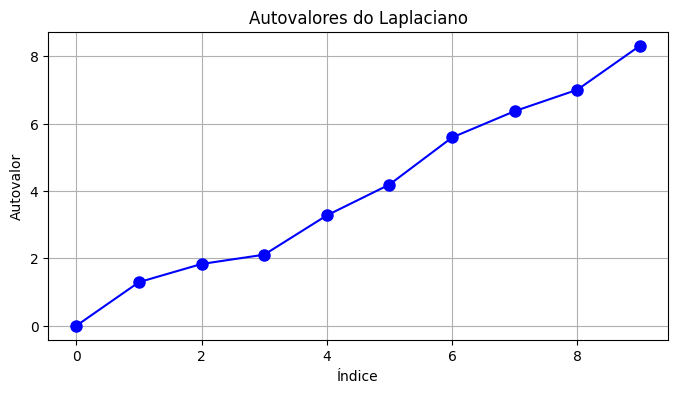

In [30]:
# Autovalores do Laplaciano
eigenvalues = np.linalg.eigvals(L)
eigenvalues_sorted = np.sort(eigenvalues)

# Plotar autovalores
plt.figure(figsize=(8, 4))
plt.plot(eigenvalues_sorted, 'bo-', markersize=8)
plt.title("Autovalores do Laplaciano")
plt.xlabel("Índice")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

Podemos decompor $\mathcal{L}$:

$$\mathcal{L} = U \Lambda U^{-1} = U \Lambda U^{\top},$$

onde $U=[u_1,\dots,u_n]$ contém os autovetores de $\mathcal{L}$ e $\Lambda = \text{diag}[\lambda_1,\dots,\lambda_n]$ é uma matriz diagonal conténdo seus respectivos autovalores. 

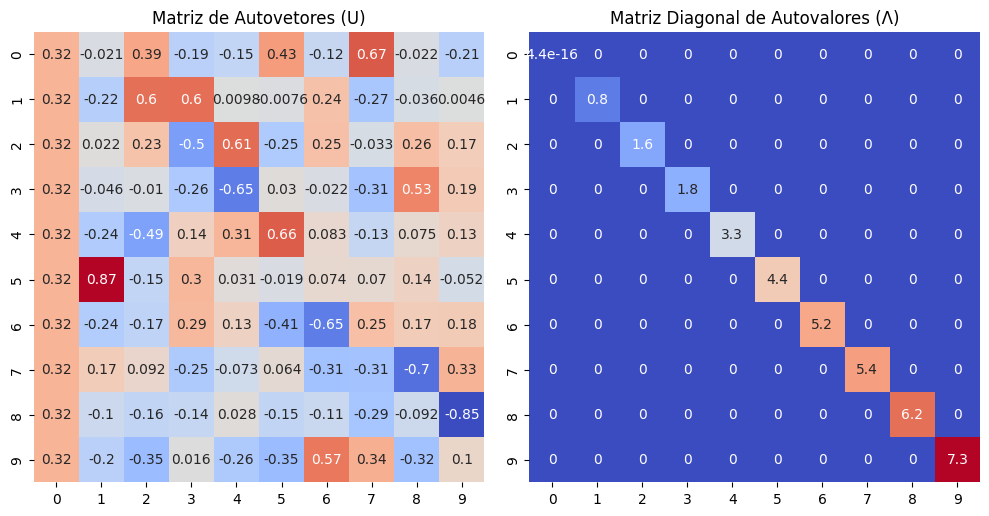

In [42]:
# Calcular autovalores (Lambda) e autovetores (U)
eigenvalues, eigenvectors = np.linalg.eigh(L)  # Use eigh para Laplaciano simétrico

# Criar a matriz diagonal Lambda com os autovalores
Lambda = np.diag(eigenvalues)

# U é a matriz de autovetores (eigenvectors)
U = eigenvectors

# Plotar as matrizes U e Lambda
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot da matriz U (autovetores)
sns.heatmap(U, ax=axes[0], cmap='coolwarm', annot=True, cbar=False, square=True)
axes[0].set_title("Matriz de Autovetores (U)")

# Plot da matriz Lambda (autovalores)
sns.heatmap(Lambda, ax=axes[1], cmap='coolwarm', annot=True, cbar=False, square=True)
axes[1].set_title("Matriz Diagonal de Autovalores (Λ)")

plt.tight_layout()
plt.show()

In [63]:
# https://medium.com/@jlcastrog99/spectral-graph-convolutions-c7241af4d8e2
# https://danielegrattarola.github.io/posts/2021-03-03/gnn-lecture-part-1.html

## Message passing

In [ ]:
# https://danielegrattarola.github.io/posts/2021-03-12/gnn-lecture-part-2.html